In [1]:
import pandas as pd
import numpy as np
from pandas_datareader.data import DataReader
from datetime import datetime
import matplotlib.pyplot as plt
from statsmodels.tsa.regime_switching.markov_autoregression import MarkovAutoregression

In [11]:
df = pd.read_csv("./data/GNP.csv")
df["GR_GNP"] = np.log(df['GNP']).diff() * 100
df["DATE"] = pd.to_datetime(df["DATE"])
df = df.iloc[1:]

In [12]:
usrec = DataReader("USREC", 
                   "fred", 
                   start=datetime(1947, 1, 1), 
                   end=datetime(2023, 10, 1))

usrec.index = pd.to_datetime(usrec.index)

In [13]:
df = df.merge(usrec, how = "left", on = "DATE")

In [18]:
df = df.rename(columns = {"USREC" : "crise"})

In [70]:
T = df.shape[0]
pi1 = df["crise"].sum()/T
pi0 = 1 - pi1
sigma0 = df[df["crise"] == 0]["GR_GNP"].std()
sigma1 = df[df["crise"] == 1]["GR_GNP"].std()
q = sigma0 / sigma1
beta0 = df[df["crise"] == 0]["GR_GNP"].mean()
beta1 = df[df["crise"] == 1]["GR_GNP"].mean()
lamda = ((beta1-beta0)**2)/sigma1**2

In [72]:
def W00():
    w = 1/T
    num = 1 + T*(lamda**2)*pi1
    den = pi1*(q**2)+pi0*(1 + T*(lamda**2)*pi1)
    w = w*(num/den)
    return w

def W01():
    w = 1/T
    num = q**2
    den = pi1*(q**2)+pi0*(1 + T*(lamda**2)*pi1)
    w = w*(num/den)
    return w

def W10():
    w = 1/T
    num = 1
    den = pi1*(q**2)+pi0*(1 + T*(lamda**2)*pi1)
    w = w*(num/den)
    return w

def W11():
    w = 1/T
    num = q**2 + T*(lamda**2)*pi0
    den = pi1*(q**2)+pi0*(1 + T*(lamda**2)*pi1)
    w = w*(num/den)
    return w

In [73]:
W00()

0.003752206654952703

In [74]:
df

,DATE,GNP,GR_GNP,crise,Modified_GR_GNP
0,1947-04-01,247.063,1.189334,0,0.004451
1,1947-07-01,250.716,1.467746,0,0.005494
2,1947-10-01,260.981,4.012678,0,0.015019
3,1948-01-01,267.133,2.329905,0,0.008720
4,1948-04-01,274.046,2.554931,0,0.009563
...,...,...,...,...,...
302,2022-10-01,26593.998,1.546472,0,0.005788
303,2023-01-01,26972.528,1.413332,0,0.005290
304,2023-04-01,27236.100,0.972443,0,0.003640
305,2023-07-01,27774.189,1.956384,0,0.007322


<Axes: >

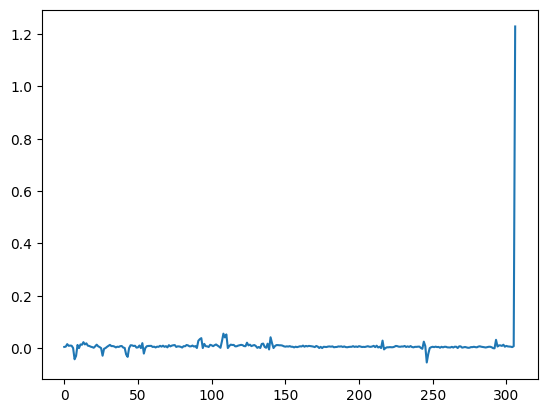

In [75]:
df["Modified_GR_GNP"].plot()

In [76]:
df['Modified_GR_GNP'] = df['GR_GNP']

for i in range(len(df) - 1):
    current_crise = df.loc[i, 'crise']
    next_crise = df.loc[i + 1, 'crise']
    if current_crise == 0 and next_crise == 0:
        df.loc[i, 'Modified_GR_GNP'] *= W00()
    elif current_crise == 0 and next_crise == 1:
        df.loc[i, 'Modified_GR_GNP'] *= W10()
    elif current_crise == 1 and next_crise == 1:
        df.loc[i, 'Modified_GR_GNP'] *= W11()
    elif current_crise == 1 and next_crise == 0:
        df.loc[i, 'Modified_GR_GNP'] *= W01()

In [77]:
df

,DATE,GNP,GR_GNP,crise,Modified_GR_GNP
0,1947-04-01,247.063,1.189334,0,0.004463
1,1947-07-01,250.716,1.467746,0,0.005507
2,1947-10-01,260.981,4.012678,0,0.015056
3,1948-01-01,267.133,2.329905,0,0.008742
4,1948-04-01,274.046,2.554931,0,0.009587
...,...,...,...,...,...
302,2022-10-01,26593.998,1.546472,0,0.005803
303,2023-01-01,26972.528,1.413332,0,0.005303
304,2023-04-01,27236.100,0.972443,0,0.003649
305,2023-07-01,27774.189,1.956384,0,0.007341


                         Markov Switching Model Results                         
Dep. Variable:          Modified_GR_GNP   No. Observations:                  305
Model:             MarkovAutoregression   Log Likelihood                1086.936
Date:                  Wed, 01 May 2024   AIC                          -2157.872
Time:                          16:17:39   BIC                          -2128.109
Sample:                               0   HQIC                         -2145.968
                                  - 305                                         
Covariance Type:                 approx                                         
                             Regime 0 parameters                              
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0062      0.000     15.881      0.000       0.005       0.007
sigma2      1.708e-05   1.72e-06    

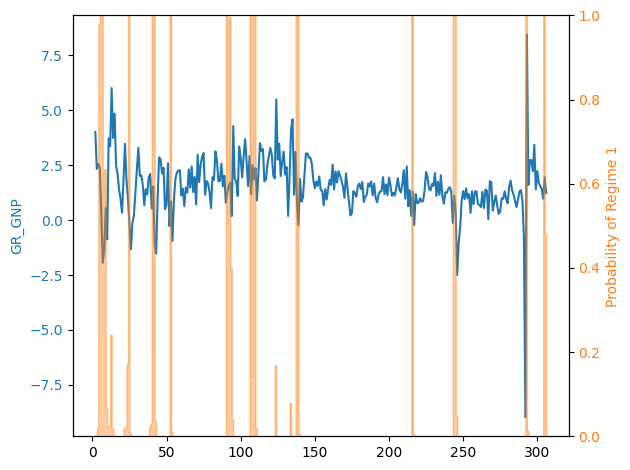

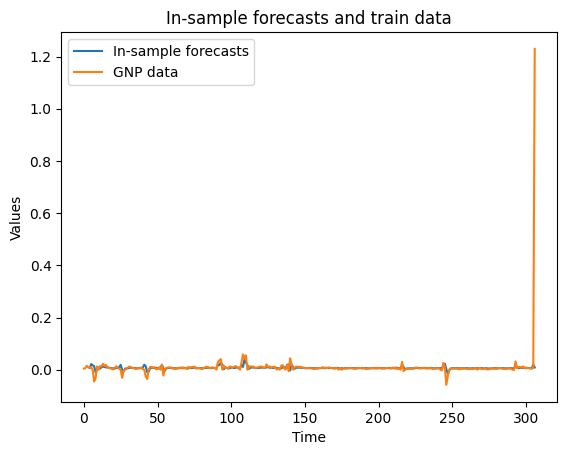

In [78]:
mar_model = MarkovAutoregression(df['Modified_GR_GNP'], k_regimes=2, order=2, switching_ar=False, switching_variance=True)
mar_res = mar_model.fit()
print(mar_res.summary())
df2 = df.iloc[2:, :]

smoothed_marginal_probabilities = mar_res.smoothed_marginal_probabilities

# Plot the series and the smoothed probabilities
fig, ax1 = plt.subplots()

ax1.plot(df2.index, df2['GR_GNP'], label='GR_GNP')
ax1.set_ylabel('GR_GNP', color='C0')
ax1.tick_params(axis='y', labelcolor='C0')

ax2 = ax1.twinx()
ax2.fill_between(df2.index, smoothed_marginal_probabilities[1], step='pre', alpha=0.4, color='C1')
ax2.set_ylabel('Probability of Regime 1', color='C1')
ax2.tick_params(axis='y', labelcolor='C1')
ax2.set_ylim([0, 1])

fig.tight_layout()
plt.show()

in_sample_forecasts = mar_res.predict()

# Plot the data
plt.plot(in_sample_forecasts, label='In-sample forecasts')
plt.plot(df['Modified_GR_GNP'], label='GNP data')

# Add axis labels and title
plt.xlabel('Time')
plt.ylabel('Values')
plt.title('In-sample forecasts and train data')

# Add legend
plt.legend()

# Show the plot
plt.show()

In [69]:
from sklearn.metrics import mean_squared_error

mean_squared_error(df["Modified_GR_GNP"].iloc[4:], in_sample_forecasts)

0.004996398504482668

In [85]:
a = "*********************"

In [86]:
len(a)

21